In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
# !pip install missingno
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from IPython.display import display

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)
pd.options.display.max_columns = None

def load_application_train():
    data = pd.read_csv("datasets/titanic.csv")
    return data


df = load_application_train()
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


In [2]:
def outlierThresholds(dataframe, colName, q1=0.25, q3=0.75):
    quartile1 = dataframe[colName].quantile(q1)
    quartile3 = dataframe[colName].quantile(q3)
    interquantileRange = quartile3 - quartile1
    upLimit = quartile3 + 1.5 * interquantileRange
    lowLimit = quartile1 - 1.5 * interquantileRange
    return lowLimit, upLimit

def checkOutlier(dataframe, colName):
    lowLimit, upLimit = outlierThresholds(dataframe, colName)
    if dataframe[(dataframe[colName] > upLimit) | (dataframe[colName] < lowLimit)].any(axis=None):
        return True
    else:
        return False
def grabColNames(dataframe, catTh=10, carTh=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        catTh: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        carTh: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        catCols: list
                Kategorik değişken listesi
        numCols: list
                Numerik değişken listesi
        catButCar: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grabColNames(df))


    Notes
    ------
        catCols + numCols + catButCar = toplam değişken sayısı
        numButCat catCols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: catCols + numCols + catButCar = değişken sayısı

    """

    # catCols, catButCar
    catCols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    numButCat = [col for col in dataframe.columns if dataframe[col].nunique() < catTh and
                 dataframe[col].dtypes != "O"]
    catButCar = [col for col in dataframe.columns if dataframe[col].nunique() > carTh and
                 dataframe[col].dtypes == "O"]
    catCols = catCols + numButCat
    catCols = [col for col in catCols if col not in catButCar]

    # numCols
    numCols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    numCols = [col for col in numCols if col not in numButCat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'catCols: {len(catCols)}')
    print(f'numCols: {len(numCols)}')
    print(f'catButCar: {len(catButCar)}')
    print(f'numButCat: {len(numButCat)}')
    return catCols, numCols, catButCar


catCols, numCols, catButCar = grabColNames(df)


for col in numCols:
    print(col, checkOutlier(df, col))

low, up = outlierThresholds(df, "Fare")
def replaceWithThreshold(dataframe, colName):
    lowLimit,upLimit = outlierThresholds(dataframe, colName)
    dataframe.loc[(dataframe[colName] < low), colName] = lowLimit
    dataframe.loc[(dataframe[colName] > up), colName] = upLimit
    return dataframe

Observations: 891
Variables: 12
catCols: 6
numCols: 3
catButCar: 3
numButCat: 4
PassengerId False
Age True
Fare True


### TITANIC UCTAN UCA FEATURE ENGINEERING % DATA PREPROCESSING

In [3]:
df.columns = [col.upper() for col in df.columns]
df.head()

,PASSENGERID,SURVIVED,PCLASS,NAME,SEX,AGE,SIBSP,PARCH,TICKET,FARE,CABIN,EMBARKED
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


In [4]:
df["NEW_CABIN_BOOL"] = df["CABIN"].notnull().astype('int64')

df["NEW_NAME_COUNT"] = df["NAME"].str.len()

df["NEW_NAME_WORD_COUNT"] = df["NAME"].apply(lambda x: len(str(x).split(" ")))

df["NEW_NAME_DR"] = df["NAME"].apply(lambda x: len([x for x in x.split() if x.startswith("Dr")]))

df["NEW_TITLE"] = df.NAME.str.extract(' ([A-Za-z]+)\.', expand=False)

df["NEW_AGE_PCLASS"] = df["AGE"] * df["PCLASS"]

df["NEW_FAMILY_SIZE"] = df["SIBSP"] + df["PARCH"] + 1

df.loc[((df["SIBSP"] + df["PARCH"]) > 0), "NEW_IS_ALONE"] = "NO"
df.loc[((df["SIBSP"] + df["PARCH"]) == 0), "NEW_IS_ALONE"] = "YES"

df.loc[(df["AGE"] < 18), "NEW_AGE_CAT"] = "young"
df.loc[(df["AGE"] >= 18) & (df["AGE"] < 56), "NEW_AGE_CAT"] = "mature"
df.loc[(df["AGE"] >= 56), "NEW_AGE_CAT"] = "senior"

df.loc[(df["SEX"] == "male") & (df["AGE"] <= 21), "NEW_SEX_CAT"] = "youngmale"
df.loc[(df["SEX"] == "male") & (df["AGE"] > 21) & (df["AGE"] <= 50), "NEW_SEX_CAT"] = "maturemale"
df.loc[(df["SEX"] == "male") & (df["AGE"] > 50), "NEW_SEX_CAT"] = "seniormale"
df.loc[(df["SEX"] == "female") & (df["AGE"] <= 21), "NEW_SEX_CAT"] = "youngfemale"
df.loc[(df["SEX"] == "female") & (df["AGE"] > 21) & (df["AGE"] <= 50), "NEW_SEX_CAT"] = "maturefemale"
df.loc[(df["SEX"] == "female") & (df["AGE"] > 50), "NEW_SEX_CAT"] = "seniorfemale"

df.head()

,PASSENGERID,SURVIVED,PCLASS,NAME,SEX,AGE,SIBSP,PARCH,TICKET,FARE,CABIN,EMBARKED,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_WORD_COUNT,NEW_NAME_DR,NEW_TITLE,NEW_AGE_PCLASS,NEW_FAMILY_SIZE,NEW_IS_ALONE,NEW_AGE_CAT,NEW_SEX_CAT
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S,0,23,4,0,Mr,66.000,2,NO,mature,maturemale
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C,1,51,7,0,Mrs,38.000,2,NO,mature,maturefemale
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S,0,22,3,0,Miss,78.000,1,YES,mature,maturefemale
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S,1,44,7,0,Mrs,35.000,2,NO,mature,maturefemale
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S,0,24,4,0,Mr,105.000,1,YES,mature,maturemale


In [5]:
catCols, numCols, catButCar = grabColNames(df)


Observations: 891
Variables: 22
catCols: 14
numCols: 5
catButCar: 3
numButCat: 8


In [6]:
numCols = [col for col in numCols if "PASSENGERID" not in col]
numCols

['AGE', 'FARE', 'NEW_NAME_COUNT', 'NEW_AGE_PCLASS']

## 2. Outliers(aykırı değerler)

In [7]:

for col in numCols:
    print(col, checkOutlier(df, col))

AGE True
FARE True
NEW_NAME_COUNT True
NEW_AGE_PCLASS True


In [8]:
for col in numCols:
    replaceWithThreshold(df, col)

In [10]:
for col in numCols:
    print(col, checkOutlier(df, col))

AGE True
FARE False
NEW_NAME_COUNT True
NEW_AGE_PCLASS False


# 3. Missing Values (Eksik Değerler)


In [11]:
def missingValuesTable(dataframe,naName = False):
    naColums = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    nMiss = dataframe[naColums].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[naColums].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missingDf = pd.concat([nMiss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missingDf,end='\n')
    if naName:
        return naColums
missingValuesTable(df)

                n_miss  ratio
CABIN              687 77.100
AGE                177 19.870
NEW_AGE_PCLASS     177 19.870
NEW_AGE_CAT        177 19.870
NEW_SEX_CAT        177 19.870
EMBARKED             2  0.220


In [12]:
df.drop("CABIN", inplace=True, axis=1)
remove_cols = ["TICKET", "NAME"]
df.drop(remove_cols, inplace=False, axis=1)

,PASSENGERID,SURVIVED,PCLASS,SEX,AGE,SIBSP,PARCH,FARE,EMBARKED,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_WORD_COUNT,NEW_NAME_DR,NEW_TITLE,NEW_AGE_PCLASS,NEW_FAMILY_SIZE,NEW_IS_ALONE,NEW_AGE_CAT,NEW_SEX_CAT
0,1,0,3,male,22.000,1,0,7.250,S,0,23,4,0,Mr,145.500,2,NO,mature,maturemale
1,2,1,1,female,38.000,1,0,65.634,C,1,51,7,0,Mrs,38.000,2,NO,mature,maturefemale
2,3,1,3,female,26.000,0,0,7.925,S,0,22,3,0,Miss,145.500,1,YES,mature,maturefemale
3,4,1,1,female,35.000,1,0,53.100,S,1,44,7,0,Mrs,35.000,2,NO,mature,maturefemale
4,5,0,3,male,35.000,0,0,8.050,S,0,24,4,0,Mr,145.500,1,YES,mature,maturemale
5,6,0,3,male,NaN,0,0,8.458,Q,0,16,3,0,Mr,NaN,1,YES,NaN,NaN
6,7,0,1,male,54.000,0,0,51.862,S,1,23,4,0,Mr,54.000,1,YES,mature,seniormale
7,8,0,3,male,2.000,3,1,21.075,S,0,30,4,0,Master,6.000,5,NO,young,youngmale
8,9,1,3,female,27.000,0,2,11.133,S,0,49,7,0,Mrs,145.500,3,NO,mature,maturefemale
9,10,1,2,female,14.000,1,0,30.071,C,0,35,5,0,Mrs,28.000,2,NO,young,youngfemale


In [13]:

df["AGE"] = df["AGE"].fillna(df.groupby("NEW_TITLE")["AGE"].transform("median"))
missingValuesTable(df)

                n_miss  ratio
NEW_AGE_PCLASS     177 19.870
NEW_AGE_CAT        177 19.870
NEW_SEX_CAT        177 19.870
EMBARKED             2  0.220


In [14]:
df["NEW_AGE_PCLASS"] = df["AGE"] * df["PCLASS"]

df.loc[(df["AGE"] < 18), "NEW_AGE_CAT"] = "young"
df.loc[(df["AGE"] >= 18) & (df["AGE"] < 56), "NEW_AGE_CAT"] = "mature"
df.loc[(df["AGE"] >= 56), "NEW_AGE_CAT"] = "senior"

df.loc[(df["SEX"] == "male") & (df["AGE"] <= 21), "NEW_SEX_CAT"] = "youngmale"
df.loc[(df["SEX"] == "male") & (df["AGE"] > 21) & (df["AGE"] <= 50), "NEW_SEX_CAT"] = "maturemale"
df.loc[(df["SEX"] == "male") & (df["AGE"] > 50), "NEW_SEX_CAT"] = "seniormale"
df.loc[(df["SEX"] == "female") & (df["AGE"] <= 21), "NEW_SEX_CAT"] = "youngfemale"
df.loc[(df["SEX"] == "female") & (df["AGE"] > 21) & (df["AGE"] <= 50), "NEW_SEX_CAT"] = "maturefemale"
df.loc[(df["SEX"] == "female") & (df["AGE"] > 50), "NEW_SEX_CAT"] = "seniorfemale"
missingValuesTable(df)

          n_miss  ratio
EMBARKED       2  0.220


In [15]:
df = df.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= 10) else x, axis=0)
missingValuesTable(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


## 4. Label Encoding


In [16]:
binaryCols = [col for col in df.columns if df[col].dtype not in ["int64", "float64"] and df[col].nunique() == 2]
binaryCols

['SEX', 'NEW_IS_ALONE']

In [17]:
def labelEncoder(dataframe, binaryCol):
    labelEncoder = LabelEncoder()
    dataframe[binaryCol] = labelEncoder.fit_transform(dataframe[binaryCol])
    return dataframe
for col in binaryCols:
    df = labelEncoder(df, col)

## 5. Rare Encoding

In [18]:
def rareAnalyzer(dataframe, target, catCols):
    for col in  catCols:
        print(col,":",len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),"RATIO": dataframe[col].value_counts() / len(dataframe),"TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")
        

In [19]:
rareAnalyzer(df, "SURVIVED", catCols)


SEX : 2
   COUNT  RATIO  TARGET_MEAN
0    314  0.352        0.742
1    577  0.648        0.189


EMBARKED : 3
   COUNT  RATIO  TARGET_MEAN
C    168  0.189        0.554
Q     77  0.086        0.390
S    646  0.725        0.339


NEW_TITLE : 17
          COUNT  RATIO  TARGET_MEAN
Capt          1  0.001        0.000
Col           2  0.002        0.500
Countess      1  0.001        1.000
Don           1  0.001        0.000
Dr            7  0.008        0.429
Jonkheer      1  0.001        0.000
Lady          1  0.001        1.000
Major         2  0.002        0.500
Master       40  0.045        0.575
Miss        182  0.204        0.698
Mlle          2  0.002        1.000
Mme           1  0.001        1.000
Mr          517  0.580        0.157
Mrs         125  0.140        0.792
Ms            1  0.001        1.000
Rev           6  0.007        0.000
Sir           1  0.001        1.000


NEW_IS_ALONE : 2
   COUNT  RATIO  TARGET_MEAN
0    354  0.397        0.506
1    537  0.603        0.304


N

In [20]:
def rareEncoder(dataframe, rarePerc):
    tempDf = dataframe.copy()
    rare_columns = [col for col in tempDf.columns if tempDf[col].dtypes == "O" and (tempDf[col].value_counts() / len(tempDf) < rarePerc).any(axis = None)]
    for var in rare_columns:
        tmp = tempDf[var].value_counts() / len(tempDf)
        rareLabels = tmp[tmp < rarePerc].index
        tempDf[var] = np.where(tempDf[var].isin(rareLabels), "Rare", tempDf[var])
    return tempDf

df = rareEncoder(df, 0.01)
df["NEW_TITLE"].value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
Rare       27
Name: NEW_TITLE, dtype: int64

## 6. One Hot Encoding


In [21]:
oheCols = [col for col in df.columns if 10 >= df[col].nunique() > 2]
oheCols

['PCLASS',
 'SIBSP',
 'PARCH',
 'EMBARKED',
 'NEW_NAME_WORD_COUNT',
 'NEW_TITLE',
 'NEW_FAMILY_SIZE',
 'NEW_AGE_CAT',
 'NEW_SEX_CAT']

In [22]:
def oneHotEncoder(dataframe, categoricalCols, drop_first = False): 
    dataframe = pd.get_dummies(dataframe, columns=categoricalCols,drop_first=drop_first)
    return dataframe
df = oneHotEncoder(df, oheCols)
df.head()

,PASSENGERID,SURVIVED,NAME,SEX,AGE,TICKET,FARE,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_DR,NEW_AGE_PCLASS,NEW_IS_ALONE,PCLASS_1,PCLASS_2,PCLASS_3,SIBSP_0,SIBSP_1,SIBSP_2,SIBSP_3,SIBSP_4,SIBSP_5,SIBSP_8,PARCH_0,PARCH_1,PARCH_2,PARCH_3,PARCH_4,PARCH_5,PARCH_6,EMBARKED_C,EMBARKED_Q,EMBARKED_S,NEW_NAME_WORD_COUNT_3,NEW_NAME_WORD_COUNT_4,NEW_NAME_WORD_COUNT_5,NEW_NAME_WORD_COUNT_6,NEW_NAME_WORD_COUNT_7,NEW_NAME_WORD_COUNT_8,NEW_NAME_WORD_COUNT_9,NEW_NAME_WORD_COUNT_14,NEW_TITLE_Master,NEW_TITLE_Miss,NEW_TITLE_Mr,NEW_TITLE_Mrs,NEW_TITLE_Rare,NEW_FAMILY_SIZE_1,NEW_FAMILY_SIZE_2,NEW_FAMILY_SIZE_3,NEW_FAMILY_SIZE_4,NEW_FAMILY_SIZE_5,NEW_FAMILY_SIZE_6,NEW_FAMILY_SIZE_7,NEW_FAMILY_SIZE_8,NEW_FAMILY_SIZE_11,NEW_AGE_CAT_mature,NEW_AGE_CAT_senior,NEW_AGE_CAT_young,NEW_SEX_CAT_maturefemale,NEW_SEX_CAT_maturemale,NEW_SEX_CAT_seniorfemale,NEW_SEX_CAT_seniormale,NEW_SEX_CAT_youngfemale,NEW_SEX_CAT_youngmale
0,1,0,Rare,1,22.000,Rare,7.250,0,23,0,66.000,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
1,2,1,Rare,0,38.000,Rare,65.634,1,51,0,38.000,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
2,3,1,Rare,0,26.000,Rare,7.925,0,22,0,78.000,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
3,4,1,Rare,0,35.000,Rare,53.100,1,44,0,35.000,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
4,5,0,Rare,1,35.000,Rare,8.050,0,24,0,105.000,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0


In [23]:
df.shape

(891, 63)

In [24]:
catCols, numCols, catButCar = grabColNames(df)

Observations: 891
Variables: 63
catCols: 58
numCols: 5
catButCar: 0
numButCat: 56


In [25]:
numCols = [col for col in numCols if "PASSENGERID" not in col]
numCols

['AGE', 'FARE', 'NEW_NAME_COUNT', 'NEW_AGE_PCLASS']

In [26]:
rareAnalyzer(df, "SURVIVED", catCols)

NAME : 1
      COUNT  RATIO  TARGET_MEAN
Rare    891  1.000        0.384


TICKET : 1
      COUNT  RATIO  TARGET_MEAN
Rare    891  1.000        0.384


SURVIVED : 2
   COUNT  RATIO  TARGET_MEAN
0    549  0.616        0.000
1    342  0.384        1.000


SEX : 2
   COUNT  RATIO  TARGET_MEAN
0    314  0.352        0.742
1    577  0.648        0.189


NEW_CABIN_BOOL : 2
   COUNT  RATIO  TARGET_MEAN
0    687  0.771        0.300
1    204  0.229        0.667


NEW_NAME_DR : 2
   COUNT  RATIO  TARGET_MEAN
0    881  0.989        0.383
1     10  0.011        0.500


NEW_IS_ALONE : 2
   COUNT  RATIO  TARGET_MEAN
0    354  0.397        0.506
1    537  0.603        0.304


PCLASS_1 : 2
   COUNT  RATIO  TARGET_MEAN
0    675  0.758        0.305
1    216  0.242        0.630


PCLASS_2 : 2
   COUNT  RATIO  TARGET_MEAN
0    707  0.793        0.361
1    184  0.207        0.473


PCLASS_3 : 2
   COUNT  RATIO  TARGET_MEAN
0    400  0.449        0.557
1    491  0.551        0.242


SIBSP_0 : 2
   COUNT  RA

In [27]:
uselessCols = [col for col in df.columns if df[col].nunique() == 2 and (df[col].value_counts() / len(df) < 0.01).any(axis=None)]
uselessCols

['SIBSP_5',
 'SIBSP_8',
 'PARCH_3',
 'PARCH_4',
 'PARCH_5',
 'PARCH_6',
 'NEW_NAME_WORD_COUNT_9',
 'NEW_NAME_WORD_COUNT_14',
 'NEW_FAMILY_SIZE_8',
 'NEW_FAMILY_SIZE_11']

## 7.Standart Scaler


In [28]:
scaler = StandardScaler()
df[numCols] = scaler.fit_transform(df[numCols])
df[numCols].head()

,AGE,FARE,NEW_NAME_COUNT,NEW_AGE_PCLASS
0,-0.561,-0.821,-0.432,0.066
1,0.663,2.032,2.668,-0.790
2,-0.255,-0.788,-0.542,0.434
3,0.434,1.419,1.893,-0.882
4,0.434,-0.781,-0.321,1.260


In [29]:
df.head()


,PASSENGERID,SURVIVED,NAME,SEX,AGE,TICKET,FARE,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_DR,NEW_AGE_PCLASS,NEW_IS_ALONE,PCLASS_1,PCLASS_2,PCLASS_3,SIBSP_0,SIBSP_1,SIBSP_2,SIBSP_3,SIBSP_4,SIBSP_5,SIBSP_8,PARCH_0,PARCH_1,PARCH_2,PARCH_3,PARCH_4,PARCH_5,PARCH_6,EMBARKED_C,EMBARKED_Q,EMBARKED_S,NEW_NAME_WORD_COUNT_3,NEW_NAME_WORD_COUNT_4,NEW_NAME_WORD_COUNT_5,NEW_NAME_WORD_COUNT_6,NEW_NAME_WORD_COUNT_7,NEW_NAME_WORD_COUNT_8,NEW_NAME_WORD_COUNT_9,NEW_NAME_WORD_COUNT_14,NEW_TITLE_Master,NEW_TITLE_Miss,NEW_TITLE_Mr,NEW_TITLE_Mrs,NEW_TITLE_Rare,NEW_FAMILY_SIZE_1,NEW_FAMILY_SIZE_2,NEW_FAMILY_SIZE_3,NEW_FAMILY_SIZE_4,NEW_FAMILY_SIZE_5,NEW_FAMILY_SIZE_6,NEW_FAMILY_SIZE_7,NEW_FAMILY_SIZE_8,NEW_FAMILY_SIZE_11,NEW_AGE_CAT_mature,NEW_AGE_CAT_senior,NEW_AGE_CAT_young,NEW_SEX_CAT_maturefemale,NEW_SEX_CAT_maturemale,NEW_SEX_CAT_seniorfemale,NEW_SEX_CAT_seniormale,NEW_SEX_CAT_youngfemale,NEW_SEX_CAT_youngmale
0,1,0,Rare,1,-0.561,Rare,-0.821,0,-0.432,0,0.066,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
1,2,1,Rare,0,0.663,Rare,2.032,1,2.668,0,-0.790,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
2,3,1,Rare,0,-0.255,Rare,-0.788,0,-0.542,0,0.434,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
3,4,1,Rare,0,0.434,Rare,1.419,1,1.893,0,-0.882,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
4,5,0,Rare,1,0.434,Rare,-0.781,0,-0.321,0,1.260,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0


## 8.Model

In [30]:
y = df["SURVIVED"]
X = df.drop(["PASSENGERID", "SURVIVED","NAME","TICKET"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

In [31]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_pred, y_test)

0.7910447761194029

In [33]:
dff = load_application_train()
dff.dropna(inplace=True)
dff = pd.get_dummies(dff, columns=["Sex", "Embarked"], drop_first=True)
y = dff["Survived"]
X = dff.drop(["PassengerId", "Survived", "Name", "Ticket", "Cabin"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)
rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_pred, y_test)

0.7090909090909091

In [34]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(10,10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importance.png")

In [35]:
y = df["SURVIVED"]
X = df.drop(["PASSENGERID", "SURVIVED","NAME","TICKET"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_pred, y_test)

0.7910447761194029

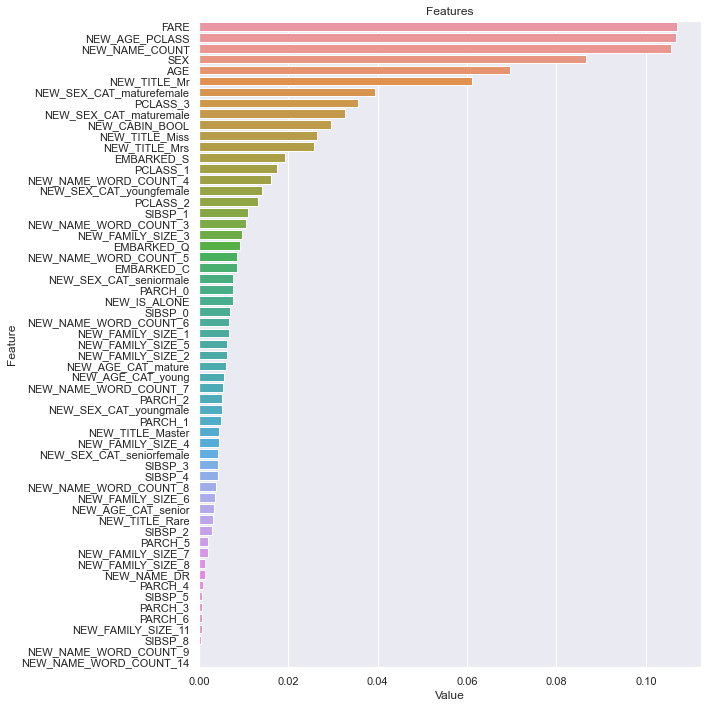

In [36]:
plot_importance(rf_model, X_train)
